# Source:

https://towardsdatascience.com/calculating-the-semantic-brand-score-with-python-3f94fb8372a6

#### Theory

https://en.wikipedia.org/wiki/Semantic_Brand_Score

### Load Data

In [1]:
import pandas as pd
BASE = 'C:\\Users\\basharm\\PythonJupyter\\CoVID19CodeGit\\data\\initial_data\\'

In [2]:
df_in = pd.read_csv(BASE+'links_only_sorted_pp.csv', encoding = 'utf8')
#df_in = df_in.iloc[:10]
df_in.head(5)

,created_at,verified,name,full_text,location,followers_count,friends_count
0,2020-03-07 11:48:47+00:00,False,occhionotizie.it,lattacco del governatore,"Salerno, Campania",2647,81
1,2020-03-07 11:48:47+00:00,False,Pierre Beaudin M.Ed.,selfquarantine challenging may think good advi...,Canada,2806,4993
2,2020-03-07 11:48:47+00:00,False,GEGENPAPST,coronavirus gesundheitsministerium beschließt ...,WAHALLA,182,1095
3,2020-03-07 11:48:48+00:00,False,Lay Zhang Thailand,200307 youku weibo update layzhang บอสมาสอนทำค...,"Bangkok, Thailand",1299,48
4,2020-03-07 11:48:48+00:00,False,Chinese Tea Master,to people think ok joke sacrifice wuhancitizen...,Belgium,101,197


In [3]:
int(len(df_in)/63)
df_in = df_in.iloc[:int(len(df_in)/63)]

In [4]:
texts = [t.split() for t in list(df_in['full_text'])]

In [22]:
int(len(df_in))

10033

### List Brands

In [5]:
#Define brands (lowercase)
brands = ['covid19', 'coronavirus']

### PREVALENCE

In [6]:
#PREVALENCE
#Import Counter and Numpy
from collections import Counter
import numpy as np

#Create a dictionary with frequency counts for each word
countPR = Counter()
for t in texts:
    countPR.update(Counter(t))

#Calculate average score and standard deviation
avgPR = np.mean(list(countPR.values()))
stdPR = np.std(list(countPR.values()))

#Calculate standardized Prevalence for each brand
PREVALENCE = {}
for brand in brands:
    PREVALENCE[brand] = (countPR[brand] - avgPR) / stdPR
    print("Prevalence", brand, PREVALENCE[brand])

Prevalence covid19 39.867188269157076
Prevalence coronavirus 146.72239776054008


### Word Network
Transform texts (list of lists of tokens) into a social network where nodes are words and links are weighted according to the number of co-occurrences between each pair of words.

In this step we have to define a co-occurrence range, i.e. a maximum distance between co-occurring words (here it is set to 7). 

In addition, we might want to remove links which represent negligible co-occurrences, for example those of weight = 1. It can also be useful to remove isolates, if these are not brands.

In [7]:
#Import Networkx
import networkx as nx

#Choose a co-occurrence range
co_range = 7

#Create an undirected Network Graph
G = nx.Graph()

In [8]:
#Each word is a network node
nodes = set([item for sublist in texts for item in sublist])
G.add_nodes_from(nodes)

In [9]:
#Add links based on co-occurrences
for doc in texts:
    w_list = []
    length= len(doc)
    for k, w in enumerate(doc):
        #Define range, based on document length
        if (k+co_range) >= length:
            superior = length
        else:
            superior = k+co_range+1
        #Create the list of co-occurring words
        if k < length-1:
            for i in range(k+1,superior):
                linked_word = doc[i].split()
                w_list = w_list + linked_word
        #If the list is not empty, create the network links
        if w_list:    
            for p in w_list:
                if G.has_edge(w,p):
                    G[w][p]['weight'] += 1
                else:
                    G.add_edge(w, p, weight=1)
        w_list = []

In [10]:
#Remove negligible co-occurrences based on a filter
link_filter = 2
#Create a new Graph which has only links above
#the minimum co-occurrence threshold
G_filtered = nx.Graph() 
G_filtered.add_nodes_from(G)
for u,v,data in G.edges(data=True):
    if data['weight'] >= link_filter:
        G_filtered.add_edge(u, v, weight=data['weight'])


In [11]:
#Optional removal of isolates
isolates = set(nx.isolates(G_filtered))
isolates -= set(brands)
G_filtered.remove_nodes_from(isolates)

In [12]:
#Check the resulting graph (for small test graphs)
#G_filtered.nodes()
#G_filtered.edges(data = True)
print("Original Network\nNo. of Nodes:", G.number_of_nodes(), "No. of Edges:", G.number_of_edges())
print("Filtered Network\nNo. of Nodes:", G_filtered.number_of_nodes(), "No. of Edges:", G_filtered.number_of_edges())


Original Network
No. of Nodes: 32924 No. of Edges: 492315
Filtered Network
No. of Nodes: 15743 No. of Edges: 93938


### Diversity and Connectivity

Having determined the co-occurrence network, we can now calculate diversity and connectivity, which are distinctiveness centrality (previously we used degree) and weighted betweenness centrality of a brand node. 

We standardize these values as we did with prevalence. More information about distinctiveness centrality is given in [this paper](https://arxiv.org/abs/1912.03391). 

You will also need to install the [Python distinctivenss package](https://github.com/iandreafc/distinctiveness).

In [13]:
#INSTALL AND IMPORT THE DISTINCTIVENESS PACKAGE
#pip install -U distinctiveness
from distinctiveness.dc import dc_all

In [14]:
#DIVERSITY
#Calculate Distinctiveness Centrality
DC = dc_all(G_filtered, normalize = False, alpha = 1)
DIVERSITY_sequence=DC["D2"]

In [15]:
#Calculate average score and standard deviation
avgDI = np.mean(list(DIVERSITY_sequence.values()))
stdDI = np.std(list(DIVERSITY_sequence.values()))
#Calculate standardized Diversity for each brand
DIVERSITY = {}
for brand in brands:
    DIVERSITY[brand] = (DIVERSITY_sequence[brand] - avgDI) / stdDI
    print("Diversity", brand, DIVERSITY[brand])

Diversity covid19 29.12204952398316
Diversity coronavirus 84.53857721178302


If we calculate connectivity as weighted betweenness centraliy, we first have to define inverse weights, as weights are treated by Networkx as distances (which is the opposite of what we want).

In [16]:
#Define inverse weights 
for u,v,data in G_filtered.edges(data=True):
    if 'weight' in data and data['weight'] != 0:
        data['inverse'] = 1/data['weight']
    else:
        data['inverse'] = 1   

#CONNECTIVITY
CONNECTIVITY_sequence=nx.betweenness_centrality(G_filtered, normalized=False, weight ='inverse')
#Calculate average score and standard deviation
avgCO = np.mean(list(CONNECTIVITY_sequence.values()))
stdCO = np.std(list(CONNECTIVITY_sequence.values()))
#Calculate standardized Prevalence for each brand
CONNECTIVITY = {}
for brand in brands:
    CONNECTIVITY[brand] = (CONNECTIVITY_sequence[brand] - avgCO) / stdCO
    print("Connectivity", brand, CONNECTIVITY[brand])

Connectivity covid19 20.10996709731845
Connectivity coronavirus 113.98189541757647


### Semantic Brand Score

The Semantic Brand Score of each brand is finally obtained by summing the standardized values of prevalence, diversity and connectivity. Different approaches are also possible.

In [17]:
#Obtain the Semantic Brand Score of each brand
SBS = {}
for brand in brands:
    SBS[brand] = PREVALENCE[brand] + DIVERSITY[brand] + CONNECTIVITY[brand]
    print("SBS", brand, SBS[brand])

SBS covid19 89.09920489045868
SBS coronavirus 345.24287038989956


In [18]:
#Generate a final pandas data frame with all results
import pandas as pd

PREVALENCE = pd.DataFrame.from_dict(PREVALENCE, orient="index", columns = ["PREVALENCE"])
DIVERSITY = pd.DataFrame.from_dict(DIVERSITY, orient="index", columns = ["DIVERSITY"])
CONNECTIVITY = pd.DataFrame.from_dict(CONNECTIVITY, orient="index", columns = ["CONNECTIVITY"])
SBS = pd.DataFrame.from_dict(SBS, orient="index", columns = ["SBS"])

SBS = pd.concat([PREVALENCE, DIVERSITY, CONNECTIVITY, SBS], axis=1, sort=False)
SBS

,PREVALENCE,DIVERSITY,CONNECTIVITY,SBS
covid19,39.867188,29.122050,20.109967,89.099205
coronavirus,146.722398,84.538577,113.981895,345.242870


### Visualise Graph

C:\Users\basharm\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\basharm\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


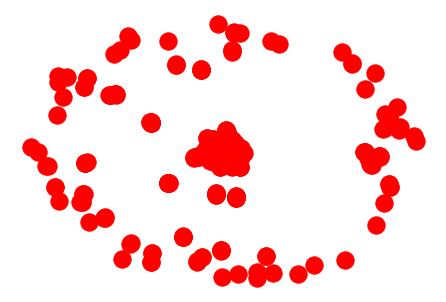

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
nx.draw(G)
plt.savefig("simple_path.png") # save as png
plt.show("simple_path.png") # display

In [20]:
# import networkx as nx
# import matplotlib.pyplot as plt
# G = nx.Graph()
# G.add_edge(1,2)
# G.add_edge(1,3)
# nx.draw(G, with_labels=True)
# plt.show()

#### Here are some other visualisations

https://semanticbrandscore.com/demographs/graphs.html